In [1]:
import logging
import pandas as pd
import os
from typing import Any
from algoshort.regime_fc import RegimeFC
from algoshort.returns import ReturnsCalculator
from algoshort.stop_loss import StopLossCalculator   # your stop-loss module
# from algoshort.position_sizing import PositionSizing  # your position sizing module
from algoshort.utils import load_config
# from algoshort.optimizer import get_equity, StrategyOptimizer
import numpy as np
from algoshort.yfinance_handler import YFinanceDataHandler
from algoshort.ohlcprocessor import OHLCProcessor
from datetime import date
from algoshort.wrappers import generate_signals

handler = YFinanceDataHandler(cache_dir="./cache", enable_logging=False)
handler.download_data(['BC.MI', 'FTSEMIB.MI'], start='2016-01-01', end=date.today(), use_cache=True)
df = handler.get_ohlc_data('BC.MI')
df['fx'] = 1
df.set_index('date')
bmk = handler.get_ohlc_data('FTSEMIB.MI')
df.columns.name = None
bmk.columns.name = None
bmk.set_index('date')

2026-02-05 21:26:47,523 - INFO - Cache hits: 2, Downloads needed: 0
2026-02-05 21:26:47,523 - INFO - Successfully processed 2/2 symbols


,open,high,low,close
date,,,,
2016-01-04,21186.0,21194.0,20702.0,20734.0
2016-01-05,20938.0,20983.0,20722.0,20983.0
2016-01-06,20922.0,20931.0,20373.0,20422.0
2016-01-07,19778.0,20289.0,19629.0,20189.0
2016-01-08,20189.0,20350.0,19869.0,19869.0
...,...,...,...,...
2026-01-28,45452.0,45473.0,44904.0,45139.0
2026-01-29,45375.0,45578.0,44985.0,45076.0
2026-01-30,45141.0,45584.0,45139.0,45527.0


In [2]:
handler.list_available_data()

{'BC.MI': {'rows': 2563,
  'columns': ['open', 'high', 'low', 'close', 'volume'],
  'date_range': '2016-01-04 to 2026-02-03',
  'missing_values': np.int64(0)},
 'FTSEMIB.MI': {'rows': 2562,
  'columns': ['open', 'high', 'low', 'close', 'volume'],
  'date_range': '2016-01-04 to 2026-02-03',
  'missing_values': np.int64(0)}}

In [3]:
from algoshort.ohlcprocessor import OHLCProcessor
processor = OHLCProcessor()
df = processor.calculate_relative_prices(
    stock_data= df,
    benchmark_data= bmk
    )

2026-02-05 21:26:47,609 - INFO - Merging primary data (shape: (2563, 6)) with benchmark data (shape: (2562, 5)).
2026-02-05 21:26:47,617 - INFO - Merge completed. New DataFrame shape: (2563, 7)
2026-02-05 21:26:47,617 - INFO - Rebasing benchmark to 1.0 using the first value: 20734.0
2026-02-05 21:26:47,617 - INFO - Calculating relative OHLC prices...
2026-02-05 21:26:47,625 - INFO - Relative price calculation complete.


In [4]:
tt_search_space = {
    'fast': [20],
    'slow': [50]
}

bo_search_space = [100]

ma_search_space = {
    'short_ma': [50],
    'medium_ma': [100],
    'long_ma': [150]
}


df, signal_columns = generate_signals(
    df=df,
    tt_search_space=tt_search_space,
    bo_search_space=bo_search_space,
    ma_search_space=ma_search_space,
)
df.columns

2026-02-05 21:26:47,658 - algoshort.regime_fc.RegimeFC - INFO - Initialized Regime_fc with DataFrame of shape (2563, 32)
2026-02-05 21:26:47,658 - INFO - Initialized Regime_fc with DataFrame of shape (2563, 32)
2026-02-05 21:26:47,662 - algoshort.regime_fc.RegimeFC - INFO - Starting regime analysis (relative=True)
2026-02-05 21:26:47,662 - INFO - Starting regime analysis (relative=True)
2026-02-05 21:26:47,663 - algoshort.regime_fc.RegimeFC - INFO - Starting swings analysis (relative=True)
2026-02-05 21:26:47,663 - INFO - Starting swings analysis (relative=True)
2026-02-05 21:26:47,666 - algoshort.regime_fc.RegimeFC - INFO - Starting historical_swings analysis (relative=True)
2026-02-05 21:26:47,666 - INFO - Starting historical_swings analysis (relative=True)
2026-02-05 21:26:47,706 - algoshort.regime_fc.RegimeFC - INFO - historical_swings completed with 4 swing levels
2026-02-05 21:26:47,706 - INFO - historical_swings completed with 4 swing levels
2026-02-05 21:26:47,730 - algoshort.r

Index Match -> Window: 100
Index Match -> short: 20, long: 50
Index Match -> short: 50, medium: 100, long: 150
Index Match -> short: 50, medium: 100, long: 150


c:\Users\l_ace\Desktop\projects\algoshort\algoshort\wrappers.py:335: UserWarning: Signal columns not generated: ['rbo_150']
  warnings.warn(f"Signal columns not generated: {missing_signals}", UserWarning)


Index(['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow',
       'rclose', 'rhi_100', 'rlo_100', 'rbo_100', 'rhi_50', 'rlo_50', 'rhi_20',
       'rlo_20', 'rbo_50', 'rbo_20', 'rtt_5020', 'rsma_short_50',
       'rsma_medium_100', 'rsma_50100', 'rsma_long_150', 'rsma_100150',
       'rsma_50100150', 'rema_short_50', 'rema_medium_100', 'rema_50100',
       'rema_long_150', 'rema_100150', 'rema_50100150', 'rh1', 'rl1', 'rh2',
       'rl2', 'rh3', 'rl3', 'rh4', 'rl4', 'rrg', 'rflr', 'rclg', 'rrg_ch'],
      dtype='object')

In [5]:
# from algoshort.combiner import HybridSignalCombiner

# combiner = HybridSignalCombiner(
#     verbose=True,
#     direction_col='rrg',
#     entry_col='rbo_100',
#     exit_col='rsma_2050100'
#     )
# df = combiner.combine_signals(df, allow_flips=True, require_regime_alignment=True)
# df

In [6]:
signal_columns = [x for x in signal_columns if x != "rrg"]
signal_columns

['rbo_100',
 'rbo_50',
 'rbo_20',
 'rtt_5020',
 'rsma_50100',
 'rsma_100150',
 'rsma_50100150',
 'rema_50100',
 'rema_100150',
 'rema_50100150']

In [7]:
# signal_columns = signal_columns[:2]

In [8]:
from algoshort.combiner import SignalGridSearch

# grid_search = SignalGridSearch(
#         df=df,
#         available_signals=signal_columns,
#         direction_col='rrg'  # Fixed direction filter
#     )

# results = grid_search.run_grid_search(
#         allow_flips=True,
#         require_regime_alignment=True,
#         verbose=False
#     )

In [9]:
# Assuming you have a DataFrame and signals
searcher = SignalGridSearch(
    df=df,
    available_signals=signal_columns,
    direction_col='rrg'
)

# Run with default settings (all cores, multiprocessing)
results = searcher.run_grid_search_parallel(
    allow_flips=True,
    require_regime_alignment=True
)

print("\nTop 5 combinations by total trades:")
print(results.nlargest(5, 'total_trades')[
    ['combination_name', 'total_trades', 'long_pct', 'short_pct']
])


# # Example 2: Controlled parallelism with joblib
# print("\n" + "="*70)
# print("EXAMPLE 2: Joblib Backend with Custom Settings")
# print("="*70)

# # Run with joblib backend and limited cores
# results = searcher.run_grid_search_parallel(
#     allow_flips=False,
#     require_regime_alignment=True,
#     n_jobs=4,              # Use only 4 cores
#     backend='joblib',      # Better error handling
#     batch_size=10,         # Process 10 combinations per batch
#     verbose=False
# )

# # Filter successful combinations
# successful = results[results['success'] == True]
# print(f"\nSuccessful combinations: {len(successful)}/{len(results)}")


# Example 3: Performance comparison
print("\n" + "="*70)
print("EXAMPLE 3: Sequential vs Parallel Performance")
print("="*70)

# import time

# # Sequential
# start = time.time()
# results_seq = searcher.run_grid_search(
#     allow_flips=True,
#     require_regime_alignment=True
# )
# seq_time = time.time() - start

# # Parallel
# start = time.time()
# results_par = searcher.run_grid_search_parallel(
#     allow_flips=True,
#     require_regime_alignment=True,
#     n_jobs=-1
# )
# par_time = time.time() - start

# print(f"\n{'='*70}")
# print("PERFORMANCE COMPARISON")
# print(f"{'='*70}")
# print(f"Sequential time: {seq_time:.2f} seconds")
# print(f"Parallel time:   {par_time:.2f} seconds")
# print(f"Speedup:         {seq_time/par_time:.2f}x")
# print(f"Cores used:      {cpu_count()}")

print("\nExamples complete. Uncomment code blocks to run.")

✓ Validation passed: All 10 signals found in dataframe

GRID GENERATION
Direction column: rrg
Available signals for entry/exit: 10
Signals: ['rbo_100', 'rbo_50', 'rbo_20', 'rtt_5020', 'rsma_50100', 'rsma_100150', 'rsma_50100150', 'rema_50100', 'rema_100150', 'rema_50100150']

Total combinations to test: 100
  = 10 entry signals × 10 exit signals

RUNNING PARALLEL GRID SEARCH
Direction column: rrg
Allow flips: True
Require regime alignment: True
Backend: multiprocessing
Parallel jobs: 22 cores

Processing 100 combinations in parallel...


Testing combinations: 100%|██████████| 100/100 [00:05<00:00, 16.73it/s]



Adding combined signal columns to main dataframe...

GRID SEARCH COMPLETE
Successful combinations: 100
Failed combinations: 0

Top 5 combinations by total trades:
              combination_name  total_trades   long_pct  short_pct
82         rema_100150__rbo_20           400  40.772532  13.343738
52         rsma_100150__rbo_20           384  37.182989  14.592275
86  rema_100150__rsma_50100150           379  44.284042  12.602419
56  rsma_100150__rsma_50100150           355  40.811549  12.251268
76   rema_50100__rsma_50100150           325  38.938744  12.680453

EXAMPLE 3: Sequential vs Parallel Performance

Examples complete. Uncomment code blocks to run.


In [10]:
# results = results[['combination_name', 'entry_signal','exit_signal', 'total_trades']]

In [11]:
# results.total_trades
# results.short_trades
# results.long_trades
results

,combination_name,entry_signal,exit_signal,direction_signal,output_column,total_trades,long_trades,short_trades,long_to_short_flips,short_to_long_flips,long_bars,short_bars,flat_bars,long_pct,short_pct,flat_pct,avg_bars_per_long_trade,avg_bars_per_short_trade,success,error
0,rbo_100__rbo_100,rbo_100,rbo_100,rrg,rbo_100__rbo_100,13,9,4,0,0,1089,492,982,42.489270,19.196254,38.314475,121.000000,123.000000,True,None
1,rbo_100__rbo_50,rbo_100,rbo_50,rrg,rbo_100__rbo_50,170,107,63,0,0,987,431,1145,38.509559,16.816231,44.674210,9.224299,6.841270,True,None
2,rbo_100__rbo_20,rbo_100,rbo_20,rrg,rbo_100__rbo_20,304,218,86,0,0,878,320,1365,34.256730,12.485369,53.257901,4.027523,3.720930,True,None
3,rbo_100__rtt_5020,rbo_100,rtt_5020,rrg,rbo_100__rtt_5020,141,92,49,0,0,1003,446,1114,39.133828,17.401483,43.464690,10.902174,9.102041,True,None
4,rbo_100__rsma_50100,rbo_100,rsma_50100,rrg,rbo_100__rsma_50100,115,89,26,0,0,1008,488,1067,39.328911,19.040187,41.630901,11.325843,18.769231,True,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,rema_50100150__rsma_100150,rema_50100150,rsma_100150,rrg,rema_50100150__rsma_100150,144,119,25,0,0,1297,323,943,50.604760,12.602419,36.792821,10.899160,12.920000,True,None
96,rema_50100150__rsma_50100150,rema_50100150,rsma_50100150,rrg,rema_50100150__rsma_50100150,180,158,22,0,0,1154,177,1232,45.025361,6.905970,48.068670,7.303797,8.045455,True,None
97,rema_50100150__rema_50100,rema_50100150,rema_50100,rrg,rema_50100150__rema_50100,137,101,36,0,0,1221,515,827,47.639485,20.093640,32.266875,12.089109,14.305556,True,None
98,rema_50100150__rema_100150,rema_50100150,rema_100150,rrg,rema_50100150__rema_100150,126,98,27,1,0,1398,165,1000,54.545455,6.437768,39.016777,14.265306,6.111111,True,None


In [12]:
# results.combination_name
# results.entry_signal
# results.exit_signal
results.output_column
# results['output_column']
# searcher.df

0                 rbo_100__rbo_100
1                  rbo_100__rbo_50
2                  rbo_100__rbo_20
3                rbo_100__rtt_5020
4              rbo_100__rsma_50100
                  ...             
95      rema_50100150__rsma_100150
96    rema_50100150__rsma_50100150
97       rema_50100150__rema_50100
98      rema_50100150__rema_100150
99    rema_50100150__rema_50100150
Name: output_column, Length: 100, dtype: object

In [13]:
signal_columns = signal_columns+results.output_column.tolist()

In [14]:
df = searcher.df
df.columns.tolist()

['date',
 'open',
 'high',
 'low',
 'close',
 'fx',
 'ropen',
 'rhigh',
 'rlow',
 'rclose',
 'rhi_100',
 'rlo_100',
 'rbo_100',
 'rhi_50',
 'rlo_50',
 'rhi_20',
 'rlo_20',
 'rbo_50',
 'rbo_20',
 'rtt_5020',
 'rsma_short_50',
 'rsma_medium_100',
 'rsma_50100',
 'rsma_long_150',
 'rsma_100150',
 'rsma_50100150',
 'rema_short_50',
 'rema_medium_100',
 'rema_50100',
 'rema_long_150',
 'rema_100150',
 'rema_50100150',
 'rh1',
 'rl1',
 'rh2',
 'rl2',
 'rh3',
 'rl3',
 'rh4',
 'rl4',
 'rrg',
 'rflr',
 'rclg',
 'rrg_ch',
 'rbo_100__rbo_100',
 'rbo_100__rbo_50',
 'rbo_100__rbo_20',
 'rbo_100__rtt_5020',
 'rbo_100__rsma_50100',
 'rbo_100__rsma_100150',
 'rbo_100__rsma_50100150',
 'rbo_100__rema_50100',
 'rbo_100__rema_100150',
 'rbo_100__rema_50100150',
 'rbo_50__rbo_100',
 'rbo_50__rbo_50',
 'rbo_50__rbo_20',
 'rbo_50__rtt_5020',
 'rbo_50__rsma_50100',
 'rbo_50__rsma_100150',
 'rbo_50__rsma_50100150',
 'rbo_50__rema_50100',
 'rbo_50__rema_100150',
 'rbo_50__rema_50100150',
 'rbo_20__rbo_100',
 '

In [16]:
from algoshort.returns import ReturnsCalculator

calc = ReturnsCalculator(
    df,
    open_col="open",      # adjust once here
    high_col="high",
    low_col="low",
    close_col="close",
    relative_prefix="r"  # or "rel_", "adj_", etc.
)

# Use relative OHLC (r_Open, r_High, ...)
df = calc.get_returns_multiple(df, signals=signal_columns, relative=True)

Computing signals:  40%|████      | 44/110 [00:01<00:02, 32.99sig/s][Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
Computing signals:  60%|██████    | 66/110 [00:01<00:00, 46.80sig/s][Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    1.5s
Computing signals: 100%|██████████| 110/110 [00:01<00:00, 60.21sig/s]
[Parallel(n_jobs=-1)]: Done  79 out of 110 | elapsed:    1.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  91 out of 110 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 103 out of 110 | elapsed:    2.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    2.2s finished


In [18]:
df.columns.tolist()

['date',
 'open',
 'high',
 'low',
 'close',
 'fx',
 'ropen',
 'rhigh',
 'rlow',
 'rclose',
 'rhi_100',
 'rlo_100',
 'rbo_100',
 'rhi_50',
 'rlo_50',
 'rhi_20',
 'rlo_20',
 'rbo_50',
 'rbo_20',
 'rtt_5020',
 'rsma_short_50',
 'rsma_medium_100',
 'rsma_50100',
 'rsma_long_150',
 'rsma_100150',
 'rsma_50100150',
 'rema_short_50',
 'rema_medium_100',
 'rema_50100',
 'rema_long_150',
 'rema_100150',
 'rema_50100150',
 'rh1',
 'rl1',
 'rh2',
 'rl2',
 'rh3',
 'rl3',
 'rh4',
 'rl4',
 'rrg',
 'rflr',
 'rclg',
 'rrg_ch',
 'rbo_100__rbo_100',
 'rbo_100__rbo_50',
 'rbo_100__rbo_20',
 'rbo_100__rtt_5020',
 'rbo_100__rsma_50100',
 'rbo_100__rsma_100150',
 'rbo_100__rsma_50100150',
 'rbo_100__rema_50100',
 'rbo_100__rema_100150',
 'rbo_100__rema_50100150',
 'rbo_50__rbo_100',
 'rbo_50__rbo_50',
 'rbo_50__rbo_20',
 'rbo_50__rtt_5020',
 'rbo_50__rsma_50100',
 'rbo_50__rsma_100150',
 'rbo_50__rsma_50100150',
 'rbo_50__rema_50100',
 'rbo_50__rema_100150',
 'rbo_50__rema_50100150',
 'rbo_20__rbo_100',
 '

In [81]:
# output_cols = grid_search.get_signal_columns()
# output_cols = results.output_column
from algoshort.wrappers import calculate_return
# df = grid_search.df
df = searcher.df
df = calculate_return(stock_data=df, signal_columns=signal_columns, relative=True)


In [82]:
df.filter(regex="chg1D_fx$")

,rbo_100_chg1D_fx,rbo_50_chg1D_fx,rbo_20_chg1D_fx,rtt_5020_chg1D_fx,rsma_50100_chg1D_fx,rsma_100150_chg1D_fx,rsma_50100150_chg1D_fx,rema_50100_chg1D_fx,rema_100150_chg1D_fx,rema_50100150_chg1D_fx,...,rema_50100150__rbo_100_chg1D_fx,rema_50100150__rbo_50_chg1D_fx,rema_50100150__rbo_20_chg1D_fx,rema_50100150__rtt_5020_chg1D_fx,rema_50100150__rsma_50100_chg1D_fx,rema_50100150__rsma_100150_chg1D_fx,rema_50100150__rsma_50100150_chg1D_fx,rema_50100150__rema_50100_chg1D_fx,rema_50100150__rema_100150_chg1D_fx,rema_50100150__rema_50100150_chg1D_fx
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,...,-0.0000,-0.0,-0.0,-0.0,-0.0000,-0.0,-0.0,-0.0000,-0.0,-0.0
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0
3,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,...,-0.0000,-0.0,-0.0,-0.0,-0.0000,-0.0,-0.0,-0.0000,-0.0,-0.0
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2558,0.5739,0.5739,0.5739,0.5739,0.5739,0.5739,-0.5739,0.5739,0.5739,-0.5739,...,0.5739,-0.0,-0.0,-0.0,0.5739,-0.0,-0.0,0.5739,-0.0,-0.0
2559,-0.4091,-0.4091,-0.4091,-0.4091,-0.4091,-0.4091,0.4091,-0.4091,-0.4091,0.4091,...,-0.4091,0.0,0.0,0.0,-0.4091,0.0,0.0,-0.4091,0.0,0.0
2560,-0.3135,-0.3135,-0.3135,-0.3135,-0.3135,-0.3135,0.3135,-0.3135,-0.3135,0.3135,...,-0.3135,0.0,0.0,0.0,-0.3135,0.0,0.0,-0.3135,0.0,0.0
2561,0.1290,0.1290,0.1290,0.1290,0.1290,0.1290,-0.1290,0.1290,0.1290,-0.1290,...,0.1290,-0.0,-0.0,-0.0,0.1290,-0.0,-0.0,0.1290,-0.0,-0.0


In [83]:
# identify cumul columns
cumul_cols = [c for c in df.columns if c.endswith("cumul")]
df_last = df.tail(1)
# pivot longer
df_long = (
    df_last.melt(
        id_vars="date",
        value_vars=cumul_cols,
        var_name="metric",
        value_name="value"
    )
)

df_long = ( df_long .sort_values("value", ascending=False) .reset_index(drop=True) )

df_long

,date,metric,value
0,2026-02-03,rsma_50100150__rema_50100_cumul,2.445209
1,2026-02-03,rema_50100__rema_100150_cumul,2.124878
2,2026-02-03,rsma_50100150__rema_50100150_cumul,2.040749
3,2026-02-03,rsma_50100__rema_50100_cumul,1.866922
4,2026-02-03,rsma_50100__rema_50100150_cumul,1.805541
...,...,...,...
105,2026-02-03,rbo_100_cumul,-0.544635
106,2026-02-03,rsma_100150_cumul,-0.609480
107,2026-02-03,rsma_50100150_cumul,-0.678809
108,2026-02-03,rtt_5020_cumul,-0.701789


In [84]:
df_long["combination_name"] = df_long["metric"].str.replace(r"_cumul$", "", regex=True)
df_long = df_long.merge(results, on='combination_name').sort_values("value", ascending=False) .reset_index(drop=True)

In [85]:
df_long.head(20)

,date,metric,value,combination_name,entry_signal,exit_signal,direction_signal,output_column,total_trades,long_trades,...,long_bars,short_bars,flat_bars,long_pct,short_pct,flat_pct,avg_bars_per_long_trade,avg_bars_per_short_trade,success,error
0,2026-02-03,rsma_50100150__rema_50100_cumul,2.445209,rsma_50100150__rema_50100,rsma_50100150,rema_50100,rrg,rsma_50100150__rema_50100,165,114,...,1178,535,850,45.961764,20.873976,33.164261,10.333333,10.490196,True,None
1,2026-02-03,rema_50100__rema_100150_cumul,2.124878,rema_50100__rema_100150,rema_50100,rema_100150,rrg,rema_50100__rema_100150,45,16,...,1318,556,689,51.424112,21.693328,26.882560,82.375000,20.592593,True,None
2,2026-02-03,rsma_50100150__rema_50100150_cumul,2.040749,rsma_50100150__rema_50100150,rsma_50100150,rema_50100150,rrg,rsma_50100150__rema_50100150,103,45,...,1268,131,1164,49.473274,5.111198,45.415529,28.177778,2.258621,True,None
3,2026-02-03,rsma_50100__rema_50100_cumul,1.866922,rsma_50100__rema_50100,rsma_50100,rema_50100,rrg,rsma_50100__rema_50100,43,30,...,1108,502,953,43.230589,19.586422,37.182989,36.933333,38.615385,True,None
4,2026-02-03,rsma_50100__rema_50100150_cumul,1.805541,rsma_50100__rema_50100150,rsma_50100,rema_50100150,rrg,rsma_50100__rema_50100150,222,32,...,1106,227,1230,43.152556,8.856808,47.990636,34.562500,1.194737,True,None
5,2026-02-03,rema_50100__rema_50100150_cumul,1.785715,rema_50100__rema_50100150,rema_50100,rema_50100150,rrg,rema_50100__rema_50100150,218,19,...,1120,274,1169,43.698790,10.690597,45.610613,58.947368,1.376884,True,None
6,2026-02-03,rema_100150__rsma_50100_cumul,1.764031,rema_100150__rsma_50100,rema_100150,rsma_50100,rrg,rema_100150__rsma_50100,245,200,...,1113,500,950,43.425673,19.508389,37.065938,5.565000,11.111111,True,None
7,2026-02-03,rsma_50100__rtt_5020_cumul,1.753009,rsma_50100__rtt_5020,rsma_50100,rtt_5020,rrg,rsma_50100__rtt_5020,131,80,...,932,440,1191,36.363636,17.167382,46.468982,11.650000,8.627451,True,None
8,2026-02-03,rsma_50100150__rema_100150_cumul,1.681882,rsma_50100150__rema_100150,rsma_50100150,rema_100150,rrg,rsma_50100150__rema_100150,122,77,...,1375,547,641,53.648069,21.342177,25.009754,17.857143,12.155556,True,None
9,2026-02-03,rema_50100150__rema_50100_cumul,1.669265,rema_50100150__rema_50100,rema_50100150,rema_50100,rrg,rema_50100150__rema_50100,137,101,...,1221,515,827,47.639485,20.093640,32.266875,12.089109,14.305556,True,None


In [86]:
# grid_search.df.columns

# grid_search.export_dataframe('all_signal.cvs')

# grid_search.df.to_excel('all_signal.xlsx')
# df.to_excel('all_signal.xlsx')

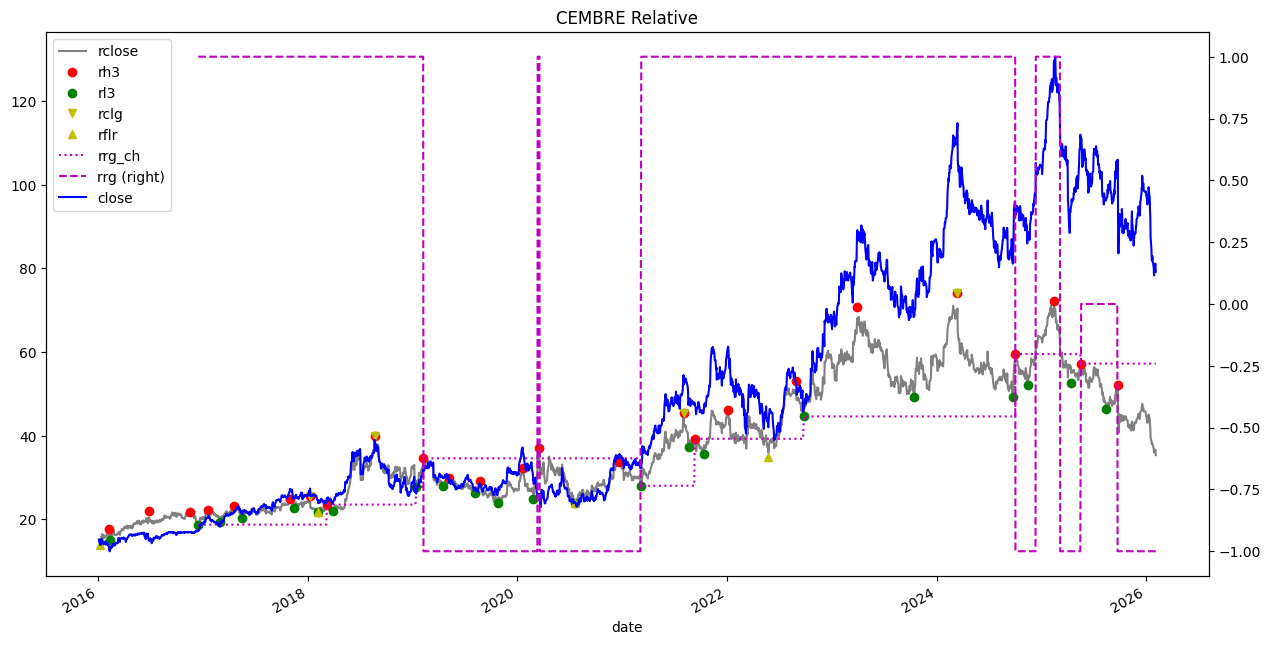

In [87]:
import matplotlib.pyplot as plt
def plot_signal_rel(df, ticker):
    
    plot_rel_cols = ['rclose','rh3','rl3','rclg','rflr','rrg_ch','rrg','close']
    plot_rel_style = ['grey','ro','go','yv','y^','m:','m--','b']  # added style for 'close'
    y2_rel = ['rrg']

    df = df.set_index('date')

    df[plot_rel_cols].plot(
        secondary_y=y2_rel,
        figsize=(15,8),
        title=str.upper(ticker) + ' Relative',
        style=plot_rel_style
    )
    plt.show()

plot_signal_rel(df, 'cembre')

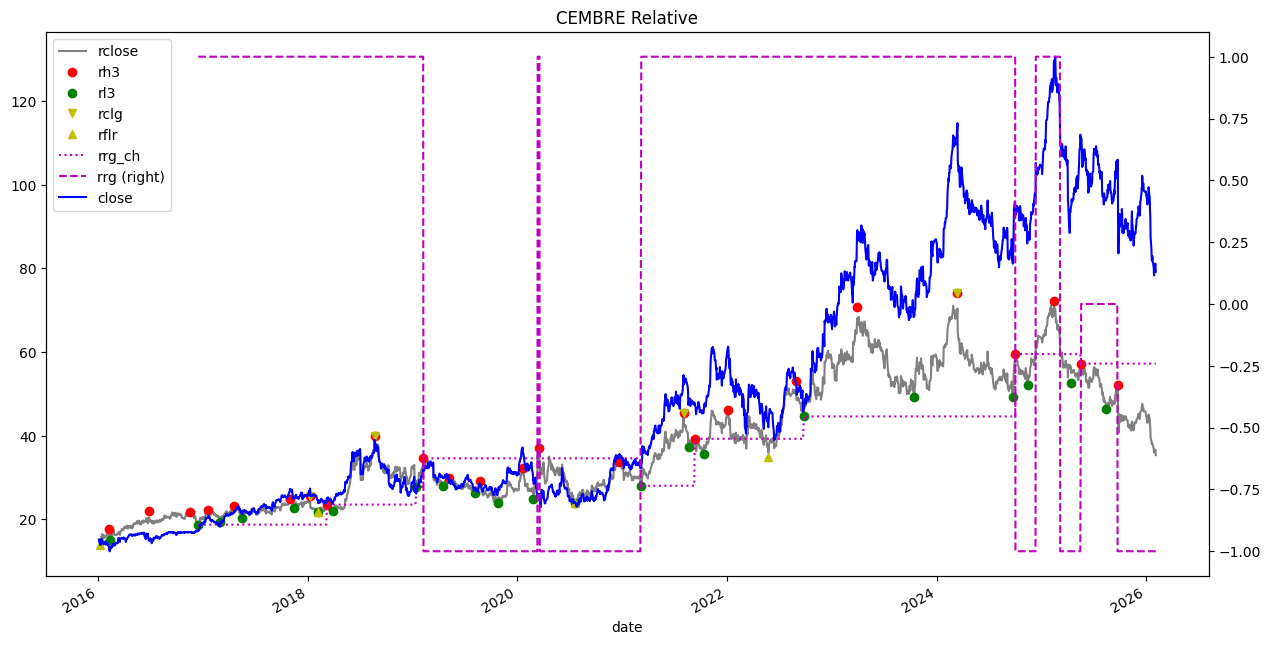

In [88]:


def plot_signal_rel(df, ticker):
    
    plot_rel_cols = ['rclose','rh3', 'rl3','rclg','rflr','rrg_ch','rrg', 'close']
    plot_rel_style = ['grey', 'ro', 'go', 'yv', 'y^','m:','m--', 'b']
    y2_rel = ['rrg']

    # df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    df[plot_rel_cols].plot(secondary_y=y2_rel,figsize=(15,8),
            title = str.upper(ticker)+ ' Relative',# grid=True,
            style=plot_rel_style)
    plt.show() 

plot_signal_rel(df, 'cembre')


In [89]:
# top= grid_search.df
# top = searcher.df
# top

In [90]:
# import matplotlib.pyplot as plt

# def plot_signal_rel(df, ticker):

#     plot_rel_cols = ['rclose','rh3','rl3','rclg','rflr','rrg', 'rema_50100__rema_50100', 'close']
#     plot_rel_style = ['grey', 'ro', 'go', 'yv', 'y^', 'k-', 'm--', 'b']
#     y2_rel = ['rema_50100__rema_50100', 'rrg']

#     df = df.set_index('date')

#     fig, ax1 = plt.subplots(figsize=(15, 8))

#     # Primary axis
#     df[plot_rel_cols].drop(columns=y2_rel).plot(
#         ax=ax1,
#         style=[s for c, s in zip(plot_rel_cols, plot_rel_style) if c not in y2_rel],
#         linewidth=1.2
#     )

#     ax1.set_ylabel("Primary metrics")
#     ax1.grid(True, linestyle="--", alpha=0.3)

#     # Secondary axis
#     ax2 = ax1.twinx()
#     df[y2_rel].plot(
#         ax=ax2,
#         style=[plot_rel_style[plot_rel_cols.index(col)] for col in y2_rel],
#         linewidth=1.5
#     )
#     ax2.set_ylabel("RRg")

#     # Title
#     fig.suptitle(f"{ticker.upper()} Relative", fontsize=16, fontweight="bold")

#     plt.show()

# plot_signal_rel(top, 'cembre')

In [91]:
# top[['date', 'rrg', 'rema_50100150', 'rema_50100150__rema_50100150']]

In [92]:
# df.filter(regex="fx$").columns
# df[]

In [1]:
from algoshort.stop_loss import StopLossCalculator
calc = StopLossCalculator(df)

for signal in signal_columns:
    df = calc.atr_stop_loss(
        signal=signal,
        window=14,
        multiplier=2
    )
    calc.data = df


NameError: name 'df' is not defined

In [94]:
# signal = 'rbo_50__rbo_50'

# from algoshort.stop_loss import StopLossCalculator
# calc = StopLossCalculator(df)
# df = calc.atr_stop_loss(
#     signal=signal,
#     window=14,
#     multiplier=2
# )
# calc.data


In [95]:
# print("Available columns:")
# print(top.columns.tolist())

# # Or more targeted:
# print("\nColumns containing 'rema':")
# print([c for c in top.columns if 'fx' in c.lower()])

# print("\nColumns containing 'chg':")
# print([c for c in top.columns if 'chg' in c.lower()])

In [96]:
(-0.01+(-0.05))/2

-0.030000000000000002

In [ ]:
# from algoshort.position_sizing import PositionSizing

# pos = PositionSizing(
#     tolerance=-0.1,
#     mn=-0.01,
#     mx=-0.05,
#     equal_weight=0.05,
#     avg=-0.03,
#     lot=1,
#     initial_capital=100000  # Optional, defaults to 100000
# )

# for signal in signal_columns:
#     df = pos.calculate_shares(
#         df=df,
#         daily_chg=signal + '_chg1D_fx',
#         sl=signal + '_stop_loss',
#         signal=signal,
#         close='close'
#     )




KeyboardInterrupt: 

In [ ]:
# df.to_excel('check.xlsx')

In [98]:
from algoshort.position_sizing import PositionSizing
from algoshort.position_sizing import run_position_sizing_parallel

sizer = PositionSizing(
    tolerance=-0.1,
    mn=-0.0025,
    mx=-0.05,
    equal_weight=0.05,
    avg=0.03,
    lot=1
)

# signals = signal_columns

df = run_position_sizing_parallel(
    sizer=sizer,
    df=df,
    signals=signal_columns,
    # Customize if your naming uses different suffixes:
    chg_suffix="_chg1D_fx",
    sl_suffix="_stop_loss",
    close_col='close',
    n_jobs=-1,
    verbose=5   # progress output
)

2026-02-05 19:33:15,006 - INFO - Processing 110 signals in parallel (n_jobs=-1)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  90 out of 110 | elapsed:   32.3s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   36.5s finished
2026-02-05 19:33:51,909 - INFO - Completed — added columns for 110 signals


In [100]:
# select date + all equity columns
df_sub = df[['date']].join(df.filter(regex='equity')).tail(1)

# pivot to long format
df_long = df_sub.melt(
    id_vars='date',
    var_name='equity_type',
    value_name='equity_value'
)

df_long["combination_name"] = df_long["equity_type"].str.replace(r"_equity_equal$", "", regex=True)
df_long = df_long.merge(results[['combination_name', 'total_trades']], on='combination_name').sort_values("equity_value", ascending=True) .reset_index(drop=True)
df_long

,date,equity_type,equity_value,combination_name,total_trades
0,2026-02-03,rema_50100150__rema_100150_equity_equal,0.0000,rema_50100150__rema_100150,126
1,2026-02-03,rbo_20__rbo_20_equity_equal,98727.2191,rbo_20__rbo_20,51
2,2026-02-03,rbo_50__rsma_100150_equity_equal,98847.9382,rbo_50__rsma_100150,157
3,2026-02-03,rbo_100__rsma_50100150_equity_equal,99035.0413,rbo_100__rsma_50100150,283
4,2026-02-03,rbo_20__rsma_100150_equity_equal,99040.0035,rbo_20__rsma_100150,188
...,...,...,...,...,...
95,2026-02-03,rema_50100__rema_50100150_equity_equal,104997.4833,rema_50100__rema_50100150,218
96,2026-02-03,rsma_50100150__rema_100150_equity_equal,105467.3973,rsma_50100150__rema_100150,122
97,2026-02-03,rsma_50100150__rema_50100_equity_equal,105591.5434,rsma_50100150__rema_50100,165
98,2026-02-03,rema_50100__rema_100150_equity_equal,105765.2425,rema_50100__rema_100150,45


In [ ]:
from algoshort.position_sizing import PositionSizing

pos = PositionSizing(
    tolerance=-0.1,
    mn=-0.01,
    mx=-0.05,
    equal_weight=-0.05,
    avg=-0.05,
    lot=1,
    initial_capital=100000  # Optional, defaults to 100000
)

df_updated = pos.calculate_shares(
    df=df,
    daily_chg=signal + '_chg1D_fx',
    sl=signal + '_stop_loss',
    signal=signal,
    close='rclose'
)

In [ ]:
df_updated.columns.tolist()

['date',
 'open',
 'high',
 'low',
 'close',
 'fx',
 'ropen',
 'rhigh',
 'rlow',
 'rclose',
 'rhi_100',
 'rlo_100',
 'rbo_100',
 'rhi_50',
 'rlo_50',
 'rhi_20',
 'rlo_20',
 'rbo_50',
 'rbo_20',
 'rtt_5020',
 'rsma_short_50',
 'rsma_medium_100',
 'rsma_50100',
 'rsma_long_150',
 'rsma_100150',
 'rsma_50100150',
 'rema_short_50',
 'rema_medium_100',
 'rema_50100',
 'rema_long_150',
 'rema_100150',
 'rema_50100150',
 'rh1',
 'rl1',
 'rh2',
 'rl2',
 'rh3',
 'rl3',
 'rh4',
 'rl4',
 'rrg',
 'rflr',
 'rclg',
 'rrg_ch',
 'rbo_100__rbo_100',
 'rbo_100__rbo_50',
 'rbo_100__rsma_50100150',
 'rbo_100__rema_50100150',
 'rbo_50__rbo_100',
 'rbo_50__rbo_50',
 'rbo_50__rsma_50100150',
 'rbo_50__rema_50100150',
 'rsma_50100150__rbo_100',
 'rsma_50100150__rbo_50',
 'rsma_50100150__rsma_50100150',
 'rsma_50100150__rema_50100150',
 'rema_50100150__rbo_100',
 'rema_50100150__rbo_50',
 'rema_50100150__rsma_50100150',
 'rema_50100150__rema_50100150',
 'rbo_100__rbo_100_chg1D',
 'rbo_100__rbo_100_chg1D_fx',
 

In [ ]:
df.filter(regex="equity")

,rbo_50__rbo_50_equity_equal,rbo_50__rbo_50_equity_constant,rbo_50__rbo_50_equity_concave,rbo_50__rbo_50_equity_convex
0,100000.0000,100000.00,100000.00,100000.00
1,100000.0000,100000.00,100000.00,100000.00
2,100000.0000,100000.00,100000.00,100000.00
3,100000.0000,100000.00,100000.00,100000.00
4,100000.0000,100000.00,100000.00,100000.00
...,...,...,...,...
2558,96785.7080,92287.59,79024.37,97909.98
2559,96836.0273,92328.50,79065.28,97950.89
2560,96874.5878,92359.85,79096.63,97982.24
2561,96858.7208,92346.95,79083.73,97969.34


In [107]:
df_updated.rsma_short_50

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
2558    43.059754
2559    42.947424
2560    42.829488
2561    42.734852
2562    42.615098
Name: rsma_short_50, Length: 2563, dtype: float64

In [3]:
optimizer = StrategyOptimizer(
    data=df,
    equity_func=get_equity,
    config_path='config.json'   # ← pass path here
)

results = optimizer.rolling_walk_forward(
    # signals='rrg',
    stop_method='atr',
    param_grid={'window': [10, 14], 'multiplier': [1.5, 2.0]},
    n_segments=4,
    opt_metric='rrg_convex'
)

2026-01-30 16:46:25,900 - algoshort.regime_fc.RegimeFC - WARNING - No peaks found, breaking loop
2026-01-30 16:46:25,900 - WARNING - No peaks found, breaking loop



=== Processing segment 0 |  stop_method='atr' ===
Input columns: ['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow', 'rclose']
Rows: 509
Stop-loss kwargs: {'window': 10, 'multiplier': 1.5}
→ Computing signal 'rrg'...
→ Computing returns...
→ Computing stop-loss using method 'atr'...
→ Computing equity curves...


2026-01-30 16:46:26,720 - algoshort.regime_fc.RegimeFC - WARNING - No peaks found, breaking loop
2026-01-30 16:46:26,720 - WARNING - No peaks found, breaking loop


Saved full segment output: segment_0_rrg_atr_output.xlsx
Segment 0 final equity (atr):
  rrg_constant: 65,147.91
  rrg_concave : 84,230.38
  rrg_convex  : 81,507.82
  rrg_equal_weight: 110,762.32
  segment_idx : 0.00
  signal      : rrg
  stop_method : atr
  rows_processed: 509.00

=== Processing segment 0 |  stop_method='atr' ===
Input columns: ['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow', 'rclose']
Rows: 509
Stop-loss kwargs: {'window': 10, 'multiplier': 2.0}
→ Computing signal 'rrg'...
→ Computing returns...
→ Computing stop-loss using method 'atr'...
→ Computing equity curves...


2026-01-30 16:46:27,408 - algoshort.regime_fc.RegimeFC - WARNING - No peaks found, breaking loop
2026-01-30 16:46:27,408 - WARNING - No peaks found, breaking loop


Saved full segment output: segment_0_rrg_atr_output.xlsx
Segment 0 final equity (atr):
  rrg_constant: 74,225.10
  rrg_concave : 88,027.70
  rrg_convex  : 86,047.42
  rrg_equal_weight: 110,762.32
  segment_idx : 0.00
  signal      : rrg
  stop_method : atr
  rows_processed: 509.00

=== Processing segment 0 |  stop_method='atr' ===
Input columns: ['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow', 'rclose']
Rows: 509
Stop-loss kwargs: {'window': 14, 'multiplier': 1.5}
→ Computing signal 'rrg'...
→ Computing returns...
→ Computing stop-loss using method 'atr'...
→ Computing equity curves...


2026-01-30 16:46:28,164 - algoshort.regime_fc.RegimeFC - WARNING - No peaks found, breaking loop
2026-01-30 16:46:28,164 - WARNING - No peaks found, breaking loop


Saved full segment output: segment_0_rrg_atr_output.xlsx
Segment 0 final equity (atr):
  rrg_constant: 60,781.37
  rrg_concave : 83,395.58
  rrg_convex  : 80,909.96
  rrg_equal_weight: 110,762.32
  segment_idx : 0.00
  signal      : rrg
  stop_method : atr
  rows_processed: 509.00

=== Processing segment 0 |  stop_method='atr' ===
Input columns: ['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow', 'rclose']
Rows: 509
Stop-loss kwargs: {'window': 14, 'multiplier': 2.0}
→ Computing signal 'rrg'...
→ Computing returns...
→ Computing stop-loss using method 'atr'...
→ Computing equity curves...
Saved full segment output: segment_0_rrg_atr_output.xlsx
Segment 0 final equity (atr):
  rrg_constant: 71,055.88
  rrg_concave : 87,440.62
  rrg_convex  : 85,551.38
  rrg_equal_weight: 110,762.32
  segment_idx : 0.00
  signal      : rrg
  stop_method : atr
  rows_processed: 509.00

=== IS results for segment 0 ===
qui

=== Processing segment 0 |  stop_method='atr' ===
Input column

In [4]:
results[0]

,date,rrg_constant,rrg_concave,rrg_convex,rrg_equal_weight,segment_idx,start_date,end_date,signal,stop_method,stop_kwargs,rows_processed,close_col,window,multiplier,segment
0,2020-01-07,102625.60,103283.28,102894.10,96154.03,0,2017-12-29,2020-01-07,rrg,atr,"{'close_col': 'close', 'window': 10, 'multipli...",509,close,10,2.0,1
1,2022-01-04,87972.11,48229.90,93068.67,109397.24,1,2020-01-08,2022-01-04,rrg,atr,"{'close_col': 'close', 'window': 14, 'multipli...",509,close,14,1.5,2
2,2024-01-02,78726.60,60049.70,84283.70,101914.60,2,2022-01-05,2024-01-02,rrg,atr,"{'close_col': 'close', 'window': 10, 'multipli...",509,close,10,1.5,3
3,2026-01-08,58994.11,16790.39,89031.37,106340.73,3,2024-01-03,2026-01-08,rrg,atr,"{'close_col': 'close', 'window': 10, 'multipli...",509,close,10,2.0,4


In [5]:
# from algoshort.regime_bo import RegimeBO
# from algoshort.regime_ma import TripleMACrossoverRegime
# from algoshort.regime_fc import RegimeFC
# from algoshort.regime_bo import RegimeBO
# from algoshort.utils import load_config, extract_signal_name

# def multiple_fc_signals(
#         config_path: str,
#         df: pd.DataFrame,
#         relative: bool = True
#         ):
    
#     # regime_fc = RegimeFC(df=df)
#     # print(*search_space.values())
#     # for lvl_val, vlty_n_val, threshold_val, d_vol_val, dist_pct_val, retrace_pct_val, r_vol_val in zip(*search_space.values()):
#     #     # print(f"Index Match -> short: {w_val}, long: {m_val}")
#     #     df = regime_fc.compute_regime(
#     #         relative = relative,
#     #         lvl = lvl_val,
#     #         vlty_n = vlty_n_val,
#     #         threshold = threshold_val,
#     #         dgt = 3,
#     #         d_vol = d_vol_val,
#     #         dist_pct = dist_pct_val,
#     #         retrace_pct = retrace_pct_val,
#     #         r_vol = r_vol_val
#     #     )
#     config = load_config(config_path)

#     regime_fc = RegimeFC(df=df)
#     df = regime_fc.compute_regime(
#         relative = relative,
#         lvl = config['regimes']['floor_ceiling']['lvl'],
#         vlty_n = config['regimes']['floor_ceiling']['vlty_n'],
#         threshold = config['regimes']['floor_ceiling']['threshold'],
#         dgt = config['regimes']['floor_ceiling']['dgt'],
#         d_vol = config['regimes']['floor_ceiling']['d_vol'],
#         dist_pct = config['regimes']['floor_ceiling']['dist_pct'],
#         retrace_pct = config['regimes']['floor_ceiling']['retrace_pct'],
#         r_vol = config['regimes']['floor_ceiling']['r_vol']
#     )
        
#     return df

# def multiple_tt_signals(
#         search_space : dict,
#         df: pd.DataFrame,
#         relative: bool = True
#         ):
    
#     regime_bo = RegimeBO(ohlc_stock=df)

#     for w_val, m_val in zip(*search_space.values()):
#         print(f"Index Match -> short: {w_val}, long: {m_val}")
#         df = regime_bo.compute_regime(regime_type='turtle', fast_window=w_val,
#                                 window=m_val,
#                                 relative=relative, inplace=True)
        
#     return df

# def multiple_bo_signals(
#         search_space,
#         df: pd.DataFrame,
#         relative: bool = True
#         ):
    
#     regime_bo = RegimeBO(ohlc_stock=df)

#     for w_val in search_space:
#         print(f"Index Match -> Window: {w_val}")
#         df = regime_bo.compute_regime(regime_type='breakout', window=w_val,
#                              relative=relative, inplace=True)
        
#     return df

# def multiple_ma_signals(
#         search_space,
#         df: pd.DataFrame,
#         relative: bool = True
#         ):
    
#     regime_ma = TripleMACrossoverRegime(ohlc_stock=df)

#     for ma_type in ['sma', 'ema']:
#         for s_val, m_val, l_val in zip(*search_space.values()):
#             print(f"Index Match -> short: {s_val}, medium: {m_val}, long: {l_val}")
#             regime_ma.compute_ma_regime(
#                 ma_type=ma_type,
#                 short_window=s_val,
#                 medium_window=m_val,
#                 long_window=l_val,
#                 relative=relative,
#                 inplace=True
#             )    
        
#     return df

# def generate_signals(
#         df: pd.DataFrame, 
#         tt_search_space: dict,
#         bo_search_space: dict,
#         ma_search_space:dict,
#         # fc_search_space:dict,
#         config_path='./config.json',
#         relative: bool = True,
#         ) -> tuple[pd.DataFrame, list]:
#     """
#     Generates signals for breakout, Turtle Trader, and MA crossover regimes.
    
#     Args:
#         df: DataFrame with OHLC data (e.g., AAPL_Open, SPY_Close).
#         symbol: Ticker symbol (e.g., 'AAPL').
#         benchmark: Benchmark ticker (e.g., 'SPY').
#         config_path: Path to JSON config file.
    
#     Returns:
#         tuple: (DataFrame with signal columns, list of signal column names).
    
#     Raises:
#         ValueError: If input DataFrame is missing required columns or config is invalid.
#     """
#     # regime_bo = RegimeBO(ohlc_stock=df)
#     # regime_ma = TripleMACrossoverRegime(ohlc_stock=df)

#     # config = load_config(config_path)

#     df = multiple_bo_signals(search_space=bo_search_space, df=df, relative=relative)
    
#     df = multiple_tt_signals(search_space=tt_search_space, df=df, relative=relative)

#     df = multiple_ma_signals(search_space=ma_search_space,df=df,relative=relative)

#     df = multiple_fc_signals(config_path,df,relative)
    
#     # Get signal column names
#     signal_names = extract_signal_name(config_path)
    
#     # Verify signal columns exist
#     missing_signals = [name for name in signal_names if name not in df.columns]
#     if missing_signals:
#         warnings.warn(f"Signal columns not generated: {missing_signals}", UserWarning)
    
#     # Select signal columns dynamically
#     signal_columns = [col for col in df.columns if any(col.startswith(prefix) for prefix in ['rbo_', 'bo_', 'rtt_', 'tt_', 'rsma_', 'sma_', 'rema_', 'ema_', 'rg', 'rrg'])]
    
#     signal_columns = [
#         item for item in signal_columns
#         if not any(keyword in item for keyword in ['short', 'medium', 'long'])
#     ]

#     return df, signal_columns

In [6]:
# tt_search_space = {
#     'fast': [10, 20, 30],
#     'slow': [50, 50, 70]
# }

# bo_search_space = [50, 100, 150]

# ma_search_space = {
#     'short_ma': [20, 50, 70],
#     'medium_ma': [50, 100, 150],
#     'long_ma': [100, 150, 200]
# }


# df, signal_columns = generate_signals(
#     df=df,
#     tt_search_space=tt_search_space,
#     bo_search_space=bo_search_space,
#     ma_search_space=ma_search_space,
# )
# df.columns

In [7]:
# from algoshort.optimizer import get_equity

# df = get_equity(
#     segment_df=df,
#     signal='rrg',
#     segment_idx=0,
#     config_path='config.json',
#     param_grid={'window': [10], 'multiplier': [1.5]}
# )

In [8]:
# df.columns

In [9]:
# sl_signal_columns = [col for col in df.columns if any(col.endswith(prefix) for prefix in ['stop_loss'])]
# sl_signal_columns

In [10]:
# df.to_excel('check.xlsx')